In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf
import pingouin as pg
import trial_correlates as tc
import tqdm
import misc

import switch_analysis_one_session as saos
reload(saos)

reload(misc)

from collections import OrderedDict

from scipy.spatial.distance import pdist, squareform, dice

67 sessions!
67 sessions!


In [2]:
db_sorted = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
ii=0
data_dir_full = db_sorted['data_dir_full'][ii]
ani = db_sorted.index[ii][0]#'e15_13f1'#'e13_26m1'
sess=db_sorted['sess_name'][ii]#'e15_13f1_220117'#'e13_26m1_210913'
print(sess)

e13_26m1_210913


In [3]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [4]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [5]:
import place_field_analysis as pf
reload(pf)
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [6]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [13]:
import test_contiguous_instability as tci

<module 'sys' (built-in)>


In [14]:
contiguous_instability_res = tci.test_contiguous_instability(data_dir_full,load_only=True,dosave=False,force_reload=False)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/instability/contiguous_instability_avg.p exists; loading---


In [19]:
contiguous_instability_res['instability_df_d'][0,0]['opt_issig']

3    0     True
27   0     True
29   0     True
     1     True
     2    False
          ...  
463  1    False
465  0    False
475  0     True
476  0     True
480  0     True
Name: opt_issig, Length: 386, dtype: bool

In [24]:
pf_res['avg']['params'][0,0].loc['fr_mean']

0          1          2          3          4          5   \
3   0   0.361854   1.660383   0.895757   0.000000   0.469987   0.000000   
27  0  14.497671  13.804467  23.114017  20.660537  24.060318  18.031251   
29  0   5.357048   8.640619  11.218283   9.660357   6.298226  16.213038   
    1   9.346967   7.827861  16.289806  15.501734   6.856234  12.040284   
    2   3.397325  16.521741  12.426897   7.661892   9.691956   6.869698   
...          ...        ...        ...        ...        ...        ...   
463 1   2.228936   0.969112   1.842748   0.203498   1.695563   1.228824   
465 0   0.001460   2.126462   0.000000   0.925933   0.000000   0.660822   
475 0  16.368606   9.114939   7.794463   7.838728   5.859289   6.816543   
476 0  10.266540   3.108913   1.702003   2.402688   1.228332   5.235973   
480 0   7.653918  11.079372   5.053644   8.949885   5.402379  10.081037   

              6          7          8          9   ...         23         24  \
3   0   0.000000   0.000000   0.000000   1.119021  ...   1.073219   1.116206   
27  0  23.890767  18.535940  16.360925  17.245221  ...  18.785730  26.555358   
29  0  13.361689  10.567988  11.872521   9.737256  ...   7.317475   0.092530   
    1  10.954014  11.643840  12.378693  13.070888  ...  17.828346  17.131333   
    2   6.792663   3.437770   5.679589  12.695125  ...  14.163162  11.938834   
...          ...        ...        ...        ...  ...        ...        ...   
463 1   0.518469   0.264381   1.150201   0.526778  ...   0.336638   0.173399   
465 0   2.779251   0.000000   2.574148   0.952779  ...   1.568812   0.000000   
475 0   6.527274   3.352123   3.790218   4.153695  ...   3.812695   0.972616   
476 0   3.623384   1.562278   1.846206   2.920560  ...   0.000000   0.000000   
480 0   5.189285   5.899786   4.334188   8.547203  ...   8.493271  13.262467   

              25         26         27         28         29         30  \
3   0   1.424825   2.067054   1.727334   2.000357   1.997971   1.820369   
27  0  22.520142  27.910965  17.187522  21.923872  31.692889  19.233423   
29  0   3.476891   1.884900   6.018258   1.828838   0.382512   6.139012   
    1  19.303846  16.753613  16.884102  11.851607  15.581193  11.995440   
    2   9.940098  15.245129  11.359280   6.171581   6.378478   7.828683   
...          ...        ...        ...        ...        ...        ...   
463 1   1.697606   0.261538   0.655295   0.486334   1.278344   0.000000   
465 0   0.623583   0.581939   1.658585   0.000000   0.706086   0.000000   
475 0   3.044497   0.305979   0.361891   2.870199   2.275909   0.265157   
476 0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
480 0  14.968596   5.325978   9.839804   4.693418  13.711597   9.497344   

              31         32  
3   0   1.468752   2.298665  
27  0  23.450917  19.769685  
29  0   0.095607   0.458614  
    1  13.127372  14.444362  
    2   4.355117   4.434275  
...          ...        ...  
463 1   0.208181   2.504769  
465 0   3.586836   0.000000  
475 0   0.813330   2.063384  
476 0   0.000000   0.000000  
480 0  13.736285  11.584210  

[386 rows x 33 columns]

In [32]:
pf_info = pf_res['avg']['all_fields'][0,0]

In [25]:
rate_map = fr_map_trial_df_d.loc[0,0].dropna(axis=1)


In [35]:
neuron,field=3,0
rm_one_chunk = rate_map.loc[neuron].loc[pf_info.loc[(neuron,field),'start']:pf_info.loc[(neuron,field),'end']]

In [42]:
def get_instability(rm):
    '''
    rm: ntrials x npos
    '''
    rm_mean = rm.mean(axis=0)
    corr = np.corrcoef(rm,rm_mean)
    insta = np.nanmean(corr[:-1,-1])
    return insta

In [45]:
pf_info

start end com peak    fr_peak    fr_mean
    field_index                                         
3   0              24  40  32   32   2.329971   1.259748
27  0               1  30  15   15   27.42802  21.757817
29  0               1  10   5    4   8.114678    7.49303
    1              20  38  29   30  22.516135  14.113698
    2              69  85  76   78  13.805456   9.883463
...               ...  ..  ..  ...        ...        ...
463 1              49  56  52   53   1.105246   0.919499
465 0              11  34  22   21   2.176381   1.154307
475 0              24  42  33   36   5.028874   3.177112
476 0              28  40  33   29   1.152027   0.991878
480 0              72  90  81   82   10.78562    7.47471

[386 rows x 6 columns]

In [51]:
insta_df = {}
for (neuron,field),row in pf_info.iterrows():
    rm_one_chunk = rate_map.loc[neuron].loc[row['start']:row['end']]
    insta = get_instability(rm_one_chunk.T.values)
    insta_df[(neuron,field)] = insta
insta_df = pd.Series(insta_df)
insta_df=insta_df.to_frame(name='instability')

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [57]:
insta_df['issig'] = contiguous_instability_res['instability_df_d'][0,0]['opt_issig']

In [61]:
insta_df.loc[(insta_df['instability'] > 0.6)&(~insta_df['issig'])]

instability  issig
45  0     0.681851  False
48  0     0.606129  False
    3     0.726414  False
57  1     0.817785  False
100 0     0.663588  False
109 0     0.739415  False
126 1     0.799904  False
127 1     0.628465  False
134 1     0.640704  False
135 1     0.713345  False
139 0     0.612353  False
140 1     0.770736  False
169 0     0.691536  False
174 0     0.719398  False
177 0     0.681045  False
190 0     0.668057  False
193 0     0.722868  False
196 0     0.788865  False
208 0     0.734792  False
228 0     0.700247  False
229 0     0.645282  False
237 1     0.622628  False
246 0     0.904478  False
265 0     0.713742  False
267 0     0.602174  False
271 0     0.613155  False
274 0     0.701471  False
275 0     0.605323  False
297 1     0.729345  False
308 0     0.711435  False
327 0     0.629087  False
395 0     0.630413  False
408 0     0.617130  False
418 0     0.693150  False
429 0     0.787022  False
440 0     0.625906  False

In [111]:
pf_info.loc[3,0]

start            24
end              40
com              32
peak             32
fr_peak    2.329971
fr_mean    1.259748
Name: (3, 0), dtype: object

In [68]:
pf_info.loc[127,1]

start            74
end              89
com              82
peak             84
fr_peak    6.920825
fr_mean    5.037848
Name: (127, 1), dtype: object

In [73]:
insta_df.loc[[(127,1),(3,0)]]

,,instability,issig
127,1,0.628465,False
3,0,0.639846,True


<AxesSubplot:>

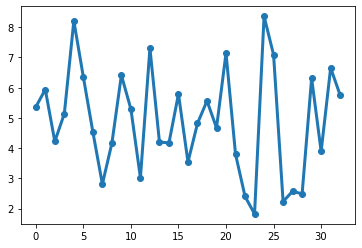

In [92]:

pf_res['avg']['params'][0,0].loc['fr_mean',127,1].plot(marker='o',linewidth=3)

In [97]:
neuron,field = 127,1
pf_info.loc[neuron,field]['start']

74

In [108]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/qual'

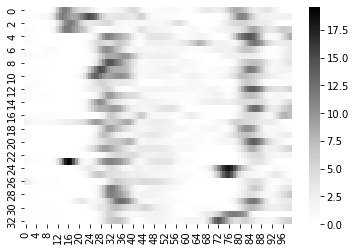

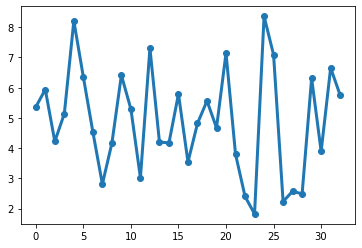

In [109]:
%matplotlib inline
# fig,axs=plt.subplots(2,1)
neuron,field = 127,1

ax=sns.heatmap(rate_map.loc[127].T,cmap='Greys')
ax.figure.savefig(os.path.join(figdir,'example_ratemap_unstructured.pdf'),bbox_inches='tight')
# ax.axline([pf_info.loc[neuron,field]['start'],0],[pf_info.loc[neuron,field]['end'],0])
# pf_res['avg']['params'][0,0].loc['fr_mean',127,1].plot(marker='o',linewidth=3,ax=axs[1])
plt.figure()
ax=pf_res['avg']['params'][0,0].loc['fr_mean',neuron,field].plot(marker='o',linewidth=3)
ax.figure.savefig(os.path.join(figdir,'example_intensity_unstructured.pdf'),bbox_inches='tight')

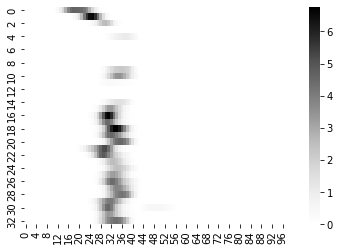

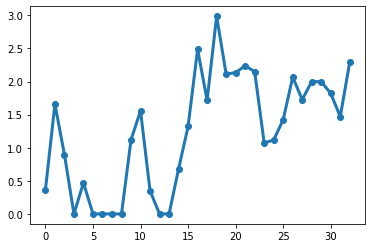

In [110]:
ax=sns.heatmap(rate_map.loc[3].T,cmap='Greys')
ax.figure.savefig(os.path.join(figdir,'example_ratemap_switch.pdf'),bbox_inches='tight')
plt.figure()
ax=pf_res['avg']['params'][0,0].loc['fr_mean',3,0].plot(marker='o',linewidth=3)
ax.figure.savefig(os.path.join(figdir,'example_intensity_switch.pdf'),bbox_inches='tight')